In [1]:
# For the UFS-MRW simulationsimport xarray as xr
import logging
import math
import os
import pdb
import pickle
import re
import warnings
from collections.abc import Iterable
from datetime import datetime, timedelta
from functools import partial
from pathlib import Path
from typing import Any, List, Optional, Tuple

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import metpy
import numpy as np
import pandas as pd
import shapely.geometry as sgeom
import xarray
import xarray as xr
from cartopy.geodesic import Geodesic
from IPython.display import HTML
from matplotlib.path import Path as mPath
from metpy.calc import dewpoint_from_relative_humidity, specific_humidity_from_dewpoint
from metpy.units import units
from utils import animate, get_obsds, getfcst, getobs, label_id, na_values, tissot

warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")

workdir = Path(os.getenv("SCRATCH")) / "ks21_tmp"


# relative_humidity_from_specific_humidity(1013.25 * units.hPa, 30 * units.degC, 18/1000).to('percent')

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Read Lupo tracked cut-off low information (obtained from D. Ahijevych)


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  This creates a geodesic circle
#  May Wong


def create_geodesic_circle(lat, lon, radius):
    # convert radius from input (km) to meters

    gd = Geodesic()
    cp = gd.circle(lon=lon, lat=lat, radius=radius * 1000.0)

    # This is long-lat coordinate system for use in ..
    # .. coordinate transformation options
    src_crs = ccrs.PlateCarree()

    # Show example
    # fig = plt.figure(figsize=(7,7))
    # ax = fig.add_subplot(111, projection=src_crs)
    # ax.coastlines(resolution='50m')
    # geoms = []
    # geoms.append(sgeom.Polygon(cp))
    # ax.add_geometries(geoms, crs=src_crs, edgecolor='r', alpha=0.5)
    # plt.show()

    return cp


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  This creates a mask based on the xlat, xlon polygon
#  May Wong


def create_mask_with_coords(coords, xlat, xlon):
    # coords is the coordinates of the polygon shape (e.g., using create_geodesic_circle)

    # MATPLOTLIB CONTAINS_POINTS METHOD TO CREATE A MASK
    x = xlon.flatten()
    y = xlat.values.flatten()
    points = np.vstack((x, y)).T

    p = mPath(coords)  # e.g., GEODESIC CIRCLE
    grid = p.contains_points(points)
    mask = grid.reshape(xlon.shape[0], xlon.shape[1])
    # plt.contourf(xlon,xlat,mask)
    # plt.colorbar()
    return mask


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Load the cutoff low objects based on the run initialization time
# May Wong

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def loadobs_col_obj(valid_time):
    obs_path = valid_time.strftime(
        "/glade/u/home/klupo/work_new/postdoc/kasugaEA21/version9/HGT_500mb/"
        f"gfs.0p25.%Y%m%d%H.f000.track"
    )
    obs = pd.read_csv(
        obs_path,
        header=0,
        sep=r"\s+",
        na_values=na_values,
    )
    return obs


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# . Adapted from Dave A. code
# This gets the list of initialization times for the specific forecast lengths (h)


def get_init_times(casedir, forecast_length):
    datepos = 0
    fdirs = sorted(casedir.glob(f"[12]?????????.F{forecast_length:03d}.C768"))

    fmt = "%Y%m%d%H"
    itimes = [pd.to_datetime(c.name[datepos : datepos + 10], format=fmt) for c in fdirs]
    print(f"found {len(itimes)} itimes with {forecast_length}-h forecasts in casedir {casedir}")

    pd.Series(itimes, name="itime")
    return itimes, fdirs


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# Given a 2D field and an object record (lat,lon center and radius (km)),
# computes the domain average.
def get_domave(field, xlon, xlat, record, scaleRo, clevels):
    lat_record = record["LAT(N)"]
    lon_record = record["LON(E)"]
    Ro_record = record["Ro(km)"] * scaleRo
    # print(lat_record, lon_record, Ro_record)

    pts = create_geodesic_circle(lat_record, lon_record, Ro_record)
    binary_field = create_mask_with_coords(pts, xlat, xlon)

    if len(field.shape) == 3:  # if 3D field
        binary_field_3d = np.zeros(field.shape, dtype=bool)
        binary_field_3d[:, :, :] = binary_field[:, :]
        newX = np.ma.array(field, mask=~binary_field_3d)

        mean_val = np.mean(np.mean(newX, axis=1), axis=1)
        return mean_val
    elif len(field.shape) == 2:  # if 2D field
        newX = np.ma.array(field, mask=~binary_field)
        mean_val = np.mean(newX)
        return mean_val
    else:
        print("get_domave: Invalid dimensions for input 'field'. STOP.")
        return
    # print("Mean = "+str(mean_val))

    # print("Plotting COL of interest and field.")

    # clim1 = np.min(newX)
    # clim2 = np.max(newX)

    # Plot the COLs of interest
    # fig = plt.figure(figsize=(11,6))

    # ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    # #plt.contourf(xlon,xlat,newX,np.linspace(clim1,clim2,20),transform=ccrs.PlateCarree(),cmap='bwr')
    # plt.contourf(xlon,xlat,newX,clevels,transform=ccrs.PlateCarree(),cmap='bwr')
    # #plt.contourf(xlon,xlat,field2d,clevels,transform=ccrs.PlateCarree(),cmap='bwr')

    # # Add coastlines
    # ax.coastlines()
    # ax.gridlines()
    # ax.set_extent([360.+min_lon, 360.+max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    # ax.set_title( record['ITIME'].values[0])

    # plt.colorbar()


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# FUNCTION TO GRAB A SINGLE GFS LEVEL GIVEN A VALID TIME
# TODO: use utils.get_obsds
def get_GFS_analyses_single_level(YYYYMMDDHH, level):
    # YYYYMMDDHH is the valid time in UTC
    # varname is one of (TMP, RH, HGT)
    # levels is the list of pressure levels (in hPa) -- only provide one

    # print("Using get_GFS_analyses_single_level(YYYYMMDDHH, varname, level) -- this returns an xrarray")
    gfs_prefix = "/glade/derecho/scratch/mwong/UFS-MRW/GFS_ANL/gfs.0p25." + YYYYMMDDHH
    fldtmp = None
    if len(level) != 1:
        print("Too many input levels. Reduce to size 1. Stop.")
        return

    for k, level in enumerate(level):
        fn = gfs_prefix + "." + str(level) + "mb.nc"
        ds_f000 = xr.open_dataset(fn, engine="netcdf4")

    return ds_f000


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# FUNCTION TO GRAB ALL GFS LEVELS GIVEN A VALID TIME
# TODO: use utils.get_obsds. It sorts lat and lon too.
def get_GFS_analyses_all_levels(YYYYMMDDHH, varname, levels):
    # YYYYMMDDHH is the valid time in UTC
    # varname is one of (TMP, RH, HGT)
    # levels is the list of pressure levels (in hPa)

    gfs_prefix = "/glade/derecho/scratch/mwong/UFS-MRW/GFS_ANL/gfs.0p25." + YYYYMMDDHH
    fldtmp = None
    for k, level in enumerate(levels):
        varname_level = varname + "_" + str(level) + "mb"

        fn = gfs_prefix + "." + str(level) + "mb.nc"
        ds_f000 = xr.open_dataset(fn, engine="netcdf4")

        # for checking if order of longitudes is the same as the interpolated UFS output
        tmp = ds_f000[varname_level].longitude.values
        larray = tmp > 180
        tmp[larray] = tmp[larray] - 360.0
        gfslon = np.zeros(shape=tmp.shape)
        gfslon[0:719] = tmp[721:]
        gfslon[720:] = tmp[0:720]

        tmp = ds_f000[varname_level][0, :, :]  # .values
        if fldtmp is None:
            dims = [len(levels), tmp.shape[0], tmp.shape[1]]
            fldtmp = np.zeros(shape=dims)
        fldtmp[k, :, 0:719] = tmp[:, 721:]
        fldtmp[k, :, 720:] = tmp[:, 0:720]
        fldtmp[k, :, :] = fldtmp[k, ::-1, :]  # flip along y-axis (latitude values)

    return fldtmp


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# FUNCTION to convert RH to specific humidity (kg/kg)
def convert_rh_to_spfh(TMP, RH, plev):
    # INPUTS:
    #    - TMP is the temperature field (2D or 3D)
    #    - RH is the relative humidity field (2D)
    #    - plev (hPa) is the pressure level at which the TMP and RH fields are on
    TMP_nlev = TMP.shape[0]
    RH_nlev = RH.shape[0]
    pres_nlev = len(plev)

    TMP_ndims = TMP.ndim
    RH_ndims = RH.ndim

    # check for shape consistency in input variables
    if TMP_ndims != RH_ndims:
        print("RH and TMP have different shapes. STOP.")
        return

    if TMP_ndims == 3 and RH_ndims == 3:
        if TMP_nlev != RH_nlev or TMP_nlev != pres_nlev:
            print("TMP, RH, and/or pressure levels do not have the same number of levels. STOP.")
            print(str(TMP_nlev) + ",  " + str(RH_nlev) + ",  " + str(pres_nlev))
            return
    elif TMP_ndims == 2 and RH_ndims == 2:
        if pres_nlev != 1:
            print("Too many input pressure levels. 2D TMP and RH fields were found. STOP.")
            print(str(TMP_ndims) + ",  " + str(RH_ndims) + ",  " + str(pres_nlev))
            return

    # convert RH to dew point
    dptanl = dewpoint_from_relative_humidity(TMP * units.K, RH * units.percent)
    spfhanl = np.zeros(shape=dptanl.shape)

    if len(plev) > 1:
        # print("More than one pressure level found")
        for k, pres in enumerate(plev):
            spfhanl[k, :, :] = specific_humidity_from_dewpoint(
                pres * units.hPa, dptanl[k, :, :]
            ).to("kg/kg")
        return spfhanl
    else:
        spfhanl = specific_humidity_from_dewpoint(plev * units.hPa, dptanl).to("kg/kg")
        return spfhanl


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# FUNCTION to process valid time based on record information (for the cut-off low)
def get_validtime_object(record_row):
    tval = record_row["ITIME"]
    tobj = pd.to_datetime(tval, format="%Y%m%d%H")

    fhval = record_row["FHOUR"]
    fhval = int(fhval.lstrip("f"))
    return tobj + timedelta(hours=fhval)


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def flip_londim(fld):
    fldtmp = fld.copy()

    if len(fldtmp.shape) == 3:
        fld = np.zeros(shape=fldtmp.shape)

        fld[:, :, 0:719] = fldtmp[:, :, 721:]
        fld[:, :, 720:] = fldtmp[:, :, 0:720]
        return fld
    elif len(fldtmp.shape) == 2:
        fld[:, 0:719] = fldtmp[:, 721:]
        fld[:, 720:] = fldtmp[:, 0:720]
        return fld
    else:
        print("flip_londim: invalid dimensions. STOP.")
        return


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def xtime(ds: xarray.Dataset):
    """convert xtime variable to datetime and assign to coordinate"""

    # remove one-element-long Time dimension
    ds = ds.squeeze(dim="Time", drop=True)

    logging.info("decode initialization time variable")
    Time = pd.to_datetime(
        ds["Times"].load().item().decode("utf-8").strip(),
        format="%Y-%m-%d_%H:%M:%S",
    )

    # assign initialization time variable to its own coordinate
    ds = ds.assign_coords(
        Time=(
            ["Time"],
            [Time],
        ),
    )
    return ds


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# FUNCTION to get the list of tendency components
def list_components(fld):
    if fld == "dt3dt":
        tendlist = [
            "deepcnv",
            "mp",
            "nonphys",
            "pbl",
            "shalcnv",
            "cnvgwd",
            "lw",
            "sw",
            "rdamp",
            "ogwd",
        ]
    elif fld == "dq3dt":
        tendlist = ["deepcnv", "mp", "nonphys", "pbl", "shalcnv"]

    return tendlist

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#
# Function to plot the polar map given a lat/lon center and a radius.
#
def draw_polar_map(global_data_2D, latc, lonc, radius, is_anl: bool):
    # INPUT variables: latc = latitude of center point (degs)
    #                  lonc = longitude of center point (degs - can be negative)
    #                  radius = radius to plot

    # Convert longitude of center positive value
    if lonc < 0:
        lonc = lonc + 360.0

    # Set up the sub-domain to plot
    minx = lonc - radius
    maxx = lonc + radius
    miny = latc - radius
    maxy = latc + radius

    # GFS analyses and UFS-MRW forecasts are processed slightly differently due to lat/lon variable conventions
    if is_anl:
        boxdata = global_data_2D.sel(longitude=slice(minx, maxx), latitude=slice(miny, maxy))
        boxlon, boxlat = boxdata.longitude, boxdata.latitude
    elif is_anl == False:
        # for forecasts that have 2D XLAT, XLONG arrays
        XLAT = global_data_2D["XLAT"][:, 0].values
        XLONG = global_data_2D["XLONG"][0, :].values
        XLONG = np.where(XLONG < 0, XLONG + 360.0, XLONG)
        indices = np.where(((XLAT >= miny) & (XLAT <= maxy)))
        boxdata = global_data_2D.isel(south_north=np.arange(np.min(indices), np.max(indices) + 1))
        indices = np.where(((XLONG >= minx) & (XLONG <= maxx)))
        boxdata = boxdata.isel(west_east=np.arange(np.min(indices), np.max(indices) + 1))

        boxlon, boxlat = boxdata.XLONG, boxdata.XLAT

    # Plotting test data on the Cartesian grid (mostly for debugging)
    # fig, ax = plt.subplots()
    # plt.pcolormesh( boxlon, boxlat, boxdata, cmap='gist_ncar' )
    # plt.colorbar()

    # convert lat/lon to radians for calculations
    boxlat = np.radians(boxlat)
    boxlon = np.radians(boxlon)
    latc = np.radians(latc)
    lonc = np.radians(lonc)

    # Using lat/lon distance
    if False:
        numerator = np.cos(boxlat) * np.sin(boxlon - lonc)
        denominator = np.cos(latc) * np.sin(boxlat) - np.sin(latc) * np.cos(boxlat) * np.cos(
            boxlon - lonc
        )
        theta = np.arctan2(numerator, denominator)
        theta = theta.where(
            theta.values > 0,
            theta.values + 2 * math.pi,
        )
        R = 1.0
        cosr = np.sin(latc) * np.sin(test_lat) + np.cos(latc) * np.cos(test_lat) * np.cos(
            test_lon - lonc
        )
        r = np.arccos(cosr / R)

        fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
        cs = ax.contourf(theta, r, test_data, cmap="bwr")  # , levels=np.linspace(5540,5810,60))
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)  # theta increasing clockwise
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_ylim([0, np.max(r)])
        cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
        fig.colorbar(cs, cax=cbaxes)

    # Using Cartesian distance
    if True:
        # define x,y based on distance (in degrees) from center
        inc = (2 * radius) / boxdata.shape[0]
        x = np.linspace(-radius, radius + inc, boxdata.shape[0] + 1)
        y = np.linspace(-radius, radius + inc, boxdata.shape[1] + 1)
        [xmesh, ymesh] = np.meshgrid(x, y)

        # calculate polar coordinates (r, theta)
        r = np.sqrt(np.power(xmesh, 2) + np.power(ymesh, 2))
        theta = np.arctan2(ymesh, xmesh)
        theta = np.where(theta < 0, theta + 2 * np.pi, theta)

        fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))

        if is_anl == False:
            boxdata = np.flipud(boxdata)

        cs = ax.pcolormesh(theta, r, boxdata, cmap="seismic", vmin=-2, vmax=2)
        # ax.contour(theta[:-1,:-1], r[:-1,:-1], boxdata, colors='k',linestyles='dashed')
        ax.yaxis.set_tick_params(labelleft=False)
        cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
        fig.colorbar(cs, cax=cbaxes)
        ax.set_ylim([0, radius])
        # print(ax.get_xticklabels())
        # ax.set_xticklabels(['90°'])
        ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
        # ax.set_xticklabels(['N', '', 'W', '', 'S', '', 'E', ''])
        return ax, theta, r, boxdata


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#
# Function to get the polar map cut-out data, along with polar coordinate info
#
def cutout_polar_map(global_data_2D, latc, lonc, radius, is_anl: bool):
    # INPUT variables: latc = latitude of center point (degs)
    #                  lonc = longitude of center point (degs - can be negative)
    #                  radius = radius to plot

    # Convert longitude of center positive value
    if lonc < 0:
        lonc = lonc + 360.0

    # Set up the sub-domain to plot
    minx = lonc - radius
    maxx = lonc + radius
    miny = latc - radius
    maxy = latc + radius

    gs = 0.25  # grid spacing
    n = round(2 * radius / gs + 1)

    # GFS analyses and UFS-MRW forecasts are processed slightly differently due to lat/lon variable conventions
    if is_anl:
        global_data_2D = global_data_2D.rename(longitude="lon", latitude="lat")
        boxdata = global_data_2D.sel(lon=slice(minx, maxx), lat=slice(miny, maxy))
        if maxy > 90:
            print(f"maxy > 90, pad with nan")
            target_lats = np.arange(miny, maxy + gs, gs)
            target_lons = np.arange(minx, maxx + gs, gs)
            # Create target grid with NaNs
            full_subset = xr.DataArray(
                np.full((n, n), np.nan),
                coords={"lat": target_lats, "lon": target_lons},
                dims=("lat", "lon"),
            )
            full_subset[0 : boxdata.lat.size, :] = boxdata
            boxdata = full_subset
        boxlon, boxlat = boxdata.lon, boxdata.lat
    elif is_anl == False:
        # for forecasts that have 2D XLAT, XLONG arrays
        XLAT = global_data_2D["XLAT"][:, 0].values
        XLONG = global_data_2D["XLONG"][0, :].values
        XLONG = np.where(XLONG < 0, XLONG + 360.0, XLONG)
        indices = np.where(((XLAT >= miny) & (XLAT <= maxy)))
        boxdata = global_data_2D.isel(south_north=np.arange(np.min(indices), np.max(indices) + 1))
        indices = np.where(((XLONG >= minx) & (XLONG <= maxx)))
        boxdata = boxdata.isel(west_east=np.arange(np.min(indices), np.max(indices) + 1))
        if maxy > 90:
            # Pad boxdata to expected size if maxy is past north pole.
            pad = n - boxdata.south_north.size
            # pad beginning of south_north dim; it goes from north to south.
            boxdata = boxdata.pad(south_north=(pad, 0))
        boxlon, boxlat = boxdata.XLONG, boxdata.XLAT

    # Plotting test data on the Cartesian grid (mostly for debugging)
    # fig, ax = plt.subplots()
    # plt.pcolormesh( boxlon, boxlat, boxdata, cmap='gist_ncar' )
    # plt.colorbar()

    # convert lat/lon to radians for calculations
    boxlat = np.radians(boxlat)
    boxlon = np.radians(boxlon)
    latc = np.radians(latc)
    lonc = np.radians(lonc)

    # Using Cartesian distance
    if True:
        # define x,y based on distance (in degrees) from center
        inc = (2 * radius) / boxdata.shape[0]
        x = np.linspace(-radius, radius + inc, boxdata.shape[0] + 1)
        y = np.linspace(-radius, radius + inc, boxdata.shape[1] + 1)
        [xmesh, ymesh] = np.meshgrid(x, y)

        # calculate polar coordinates (r, theta)
        r = np.sqrt(np.power(xmesh, 2) + np.power(ymesh, 2))
        theta = np.arctan2(ymesh, xmesh)
        theta = np.where(theta < 0, theta + 2 * np.pi, theta)

        if is_anl == False:
            boxdata = np.flipud(boxdata)

        return theta, r, boxdata

In [55]:
# *********************************************
#
# START LOADING THE FORECAST(S) OF INTEREST
#
# *********************************************v

casedir = Path("/glade/campaign/mmm/parc/mwong/ufs-mrw")

forecast_length = 72
twin = 18

# Look at Day 4 from 10-day forecasts
itimes, fdirs = get_init_times(casedir, 240 if forecast_length == 96 else forecast_length)
print(itimes)
print(len(fdirs))
PKL_DIR = Path(f"/glade/derecho/scratch/{os.getenv('USER')}/UFS-MRW/TENDS_pickles")

found 24 itimes with 72-h forecasts in casedir /glade/campaign/mmm/parc/mwong/ufs-mrw
[Timestamp('2019-10-23 06:00:00'), Timestamp('2019-11-24 06:00:00'), Timestamp('2019-12-20 00:00:00'), Timestamp('2020-02-09 06:00:00'), Timestamp('2020-02-20 12:00:00'), Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-06 12:00:00'), Timestamp('2020-04-09 12:00:00'), Timestamp('2020-05-16 12:00:00'), Timestamp('2020-08-29 18:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-10-25 18:00:00'), Timestamp('2020-11-25 06:00:00'), Timestamp('2021-03-14 18:00:00'), Timestamp('2021-04-09 00:00:00'), Timestamp('2021-04-11 12:00:00'), Timestamp('2021-04-28 06:00:00'), Timestamp('2021-10-16 18:00:00'), Timestamp('2021-10-26 06:00:00'), Timestamp('2021-12-31 06:00:00'), Timestamp('2022-02-13 12:00:00'), Timestamp('2022-04-11 06:00:00'), Timestamp('2022-05-02 12:00:00'), Timestamp('2022-06-11 18:00:00')]
24


In [56]:
cutoffs = {
    2019102606: 32379,
    2019112706: 33027,
    2019122300: 33453,
    2020021206: 34433,
    2020022312: 34695,
    2020030400: 34916,
    2020040912: 35563,
    2020041212: 35563,
    2020051912: 36483,
    # 2020090118: 38541,  # west, not east at f048, f072; okay f096
    2020091000: 38671,
    2020102818: 39553,  # ignore 39600 TC
    2020112806: 40236,
    2021031718: 42385,
    # 2021041200: 42948,  # northwest, not east at f072
    # 2021041412: 42904(f072), 43078(f096) # matching is messy
    2021050106: 43351,
    2021101918: 46789,
    2021102906: 46950,
    2022010306: 48354,  # unmatches at f066
    2022021612: 49289,
    2022041406: 50591,
    2022050512: 51124,
    2022061418: 52004,
}

In [57]:
%%time
fn = PKL_DIR / f"DS_F{forecast_length:03d}_over_{twin}h.pkl"

if Path(fn).is_file():
    with open(fn, "rb") as data:
        [ds, ds_p] = pickle.load(data)
else:
    listoffiles = []
    for itime, fdir in zip(itimes, fdirs):
        ifile = fdir / f"interp/interp_fv3_history2d_{itime:%Y%m%d%H}_f{forecast_length:03d}.nc"
        listoffiles.append(ifile)
    print(listoffiles)

    ds = xarray.open_mfdataset(
        listoffiles, preprocess=xtime, compat="override", coords="minimal"
    )

    logging.warning(f"opened {len(listoffiles)} files")
    logging.info(listoffiles)

    # now also load the twin-h previous files to get the tendencies over that twin-h period
    listoffiles = []
    for itime, fdir in zip(itimes, fdirs):
        ifile = (
            fdir / f"interp/interp_fv3_history2d_{itime:%Y%m%d%H}_f{forecast_length - twin:03d}.nc"
        )
        listoffiles.append(ifile)
    print(listoffiles)

    ds_p = xarray.open_mfdataset(
        listoffiles, preprocess=xtime, parallel=True, compat="override", coords="minimal"
    )

    logging.warning(f"opened {len(listoffiles)} files")
    logging.info(listoffiles)

    # SAVE THE DATASET IN A PICKLE FILE
    with open(fn, "wb") as output:
        pickle.dump([ds, ds_p], output)

CPU times: user 6.72 s, sys: 47.8 ms, total: 6.76 s
Wall time: 6.82 s


In [58]:
# GRAB LAT/LON VALUES

levels = [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100]

print(ds["dt3dt500_deepcnv"].XLAT)
xlat = ds["dt3dt500_deepcnv"].XLAT
xlontmp = ds["dt3dt500_deepcnv"].XLONG
xlon = np.zeros(shape=xlontmp.shape)
xlon[:, 0:719] = xlontmp[
    :, 721:
]  # if you get error about DataArray has no .values attribute, your pickle file is old and read incorrectly. Try NPL 2024a kernel
xlon[:, 720:] = xlontmp[:, 0:720]

<xarray.DataArray 'XLAT' (south_north: 721, west_east: 1440)> Size: 4MB
dask.array<getitem, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
    XLONG    (south_north, west_east) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Attributes:
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north
    MemoryOrder:  XY
    stagger:      
    FieldType:    104


In [59]:
# FIRST, FIND THE COL OF INTEREST

# set domain of interest to limit the number of COL to average over
min_lat = 10.0
max_lat = 45.0
min_lon = -120.0
max_lon = -80.0
df = pd.concat(
    [getfcst(itime, itime + pd.Timedelta(hours=forecast_length), workdir) for itime in itimes]
)
Ro_lim = 2500.0

print(f"Filtering: {forecast_length} {min_lat} {max_lat} {min_lon} {max_lon} {Ro_lim} ID FERRX")

# Filter by location, object size, valid ID, and zonal error
record = df[
    (df["FHOUR"] == f"f{forecast_length:03d}")
    & (df["LAT(N)"] >= min_lat)
    & (df["LAT(N)"] <= max_lat)
    & (df["LON(E)"] <= max_lon + 360.0)
    & (df["LON(E)"] >= min_lon + 360.0)
    & (df["Ro(km)"] <= Ro_lim)
]
record[["ITIME", "ID", "LAT(N)", "FERRX(km)"]].reset_index(drop=True)

# Drop repeated IDs (keep the first entry)
# Let's not do this. It chooses the wrong record (34961) for itime 2020030100. Should be 34916.
# Additionally, it drops 2020040912 35563 (because 2020040612 35563 precedes)
duplicate_rows = record[record.duplicated(subset=["ID"])]
print(f"drop duplicates {[(r.ITIME, r.ID) for _,r in duplicate_rows.iterrows()]}")

record = record.drop_duplicates(subset=["ID"], keep="first")

# Filter by date also
# record = record[record["ITIME"] == 2020040612]

print("Number of COLs found: " + str(len(record)))

Filtering: 72 10.0 45.0 -120.0 -80.0 2500.0 ID FERRX
drop duplicates [(2020040912, 35563.0), (2021041112, 42904.0), (2022061118, nan)]
Number of COLs found: 24


In [60]:
may_records = set(zip(record.ITIME, record.ID))
may_records

{(2019102306, 32379.0),
 (2019112406, 33027.0),
 (2019122000, 33453.0),
 (2020020906, 34433.0),
 (2020022012, 34695.0),
 (2020030100, 34916.0),
 (2020030100, 34961.0),
 (2020040612, 35563.0),
 (2020051612, 36483.0),
 (2020082918, 38541.0),
 (2020090700, 38671.0),
 (2020102518, 39553.0),
 (2020102518, 39600.0),
 (2020112506, 40236.0),
 (2021031418, 42385.0),
 (2021040900, 42904.0),
 (2021040900, 42948.0),
 (2021041112, nan),
 (2021042806, 43351.0),
 (2021101618, 46789.0),
 (2021102606, 46950.0),
 (2022021312, 49289.0),
 (2022050212, 51124.0),
 (2022061118, 52004.0)}

In [61]:
# ******************************************************************************************
# Counting number of COL in analyses and then match ID to the forecast objects
# ******************************************************************************************

count = 0

record_obs_save = pd.DataFrame()
record_fcst_save = []

for _, record_row in record.iterrows():
    validtime = record_row.valid_time

    df_obs = loadobs_col_obj(validtime)
    record_obs = df_obs[
        (df_obs["LAT(N)"] >= min_lat)
        & (df_obs["LAT(N)"] <= max_lat)
        & (df_obs["LON(E)"] <= max_lon + 360.0)
        & (df_obs["LON(E)"] >= min_lon + 360.0)
    ]
    record_obs = record_obs[record_obs["Ro(km)"] <= Ro_lim]
    # print(len(record_obs))

    if np.isnan(record_row["ID"]):
        print(f"{validtime} ID is null")
    else:
        if len(record_obs) > 1:
            print(
                f"{validtime} found {len(record_obs)} obs {[r.ID for _,r in record_obs.iterrows()]}"
            )
            for i in np.arange(0, len(record_obs)):
                if record_obs.iloc[[i]]["ID"].values == record_row["ID"]:
                    count = count + 1
                    print(
                        f'count: {count} Found match ID: {record_obs.iloc[[i]]["ID"].values}  {record_row["ID"]}'
                    )
                    record_obs_save = pd.concat([record_obs_save, record_obs.iloc[[i]]])
                    record_fcst_save.append(record_row)
                else:
                    print(f'Unmatched: {record_obs.iloc[[i]]["ID"].values} {record_row["ID"]}')
        else:
            if record_obs["ID"].values == record_row["ID"]:
                count = count + 1
                # print(str(count)+" Found match ID: "+str(int(record_obs["ID"]))+"  "+str(int(record_row["ID"])))
                record_obs_save = pd.concat([record_obs_save, record_obs])
                record_fcst_save.append(record_row)
            else:
                print(f'Unmatched obs: {record_obs["ID"].values} fcst: {record_row["ID"]}')

record_fcst_save = pd.concat(record_fcst_save, axis=1).T
print(f"Number of observed COLs found: {len(record_obs_save)}")
print(f"Number of forecast COLs matched: {len(record_fcst_save)}")

Unmatched obs: [34916] fcst: 34961.0
2020-04-09 12:00:00 found 2 obs [35563, 35678]
count: 7 Found match ID: [35563]  35563.0
Unmatched: [35678] 35563.0
2020-05-19 12:00:00 found 2 obs [36345, 36483]
Unmatched: [36345] 36483.0
count: 8 Found match ID: [36483]  36483.0
2020-10-28 18:00:00 found 2 obs [39600, 39553]
Unmatched: [39600] 39553.0
count: 11 Found match ID: [39553]  39553.0
2020-10-28 18:00:00 found 2 obs [39600, 39553]
count: 12 Found match ID: [39600]  39600.0
Unmatched: [39553] 39600.0
2021-04-12 00:00:00 found 2 obs [42948, 42904]
Unmatched: [42948] 42904.0
count: 15 Found match ID: [42904]  42904.0
2021-04-12 00:00:00 found 2 obs [42948, 42904]
count: 16 Found match ID: [42948]  42948.0
Unmatched: [42904] 42948.0
2021-04-14 12:00:00 ID is null
Number of observed COLs found: 22
Number of forecast COLs matched: 22


In [65]:
itime = pd.to_datetime("2022123106", format="%Y%m%d%H")
extent = (-125, -75, 20, 50)
# Choose one of the initializations of itimes.
fig, ax = plt.subplots(
    subplot_kw={"projection": cartopy.crs.LambertConformal()},
)
ax.set_extent(extent)
coastlines = ax.coastlines(lw=0.25)
gridlines = ax.gridlines(lw=0.25, alpha=0.5)
ax.add_feature(cartopy.feature.STATES, lw=0.2, alpha=0.5)
func = partial(
    animate,
    ax=ax,
    itime=itime,
    workdir=workdir,
    forecast_length=forecast_length,
)

freq = "6h"
suptitle = f"init time: {itime}  forecast length: {forecast_length:03d}h  freq:{freq}"
fig.suptitle(suptitle)
valid_times = pd.date_range(start=itime, end=itime + pd.Timedelta(hours=forecast_length), freq=freq)
ani = matplotlib.animation.FuncAnimation(fig, func, frames=valid_times, init_func=lambda: None)

plt.close(fig)
HTML(ani.to_jshtml())

2022-12-31 06:00:00

FileNotFoundError: [Errno 2] No such file or directory: '/glade/u/home/klupo/work_new/postdoc/kasugaEA21/version9/HGT_500mb/gfs.0p25.2022123106.f000.track'

In [49]:
may_fcst_save = record_fcst_save.copy()
may_obs_save = record_obs_save.copy()

In [50]:
filtered_may_records = set(zip(record_fcst_save.ITIME, record_fcst_save.ID))
may_records - filtered_may_records

{(2019102206, nan), (2019112306, 32958.0), (2020022900, 34961.0)}

In [51]:
filtered_may_records

{(2019102206, 32379.0),
 (2019112306, 33027.0),
 (2019121900, 33453.0),
 (2020020806, 34433.0),
 (2020021912, 34695.0),
 (2020022900, 34916.0),
 (2020040512, 35563.0),
 (2020040512, 35678.0),
 (2020051512, 36345.0),
 (2020051512, 36483.0),
 (2020082818, 38541.0),
 (2020090600, 38671.0),
 (2020102418, 39553.0),
 (2020112406, 40236.0),
 (2021031318, 42385.0),
 (2021040800, 42948.0),
 (2021041012, 43078.0),
 (2021042706, 43351.0),
 (2021101518, 46789.0),
 (2021102506, 46950.0),
 (2022021212, 49289.0),
 (2022050112, 51124.0),
 (2022061018, 52004.0)}

In [52]:
for itime in itimes:
    itime = int(itime.strftime("%Y%m%d%H"))
    if itime not in [x for x, y in filtered_may_records]:
        print(itime)

2020040812
2021123006
2022041006


In [53]:
record_obs_save = []
record_fcst_save = []

for case, ID in cutoffs.items():
    case = pd.to_datetime(case, format="%Y%m%d%H")
    fcst = getfcst(case - timedelta(hours=forecast_length), case, workdir, ids=[ID]).squeeze()
    if fcst.empty:
        continue
    obs = getobs(case, ids=[ID]).squeeze()
    assert obs["Ro(km)"] <= Ro_lim
    record_obs_save.append(obs)
    record_fcst_save.append(fcst)
record_obs_save = pd.concat(record_obs_save, axis=1).T
record_fcst_save = pd.concat(record_fcst_save, axis=1).T
print(f"Number of observed COLs found: {len(record_obs_save)}")
print(f"Number of forecast COLs matched: {len(record_fcst_save)}")
daa_records = set(zip(record_fcst_save.ITIME, record_fcst_save.ID))

Number of observed COLs found: 21
Number of forecast COLs matched: 21


/glade/derecho/scratch/ahijevyc/tmp/ipykernel_50050/272250692.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["old","new"])


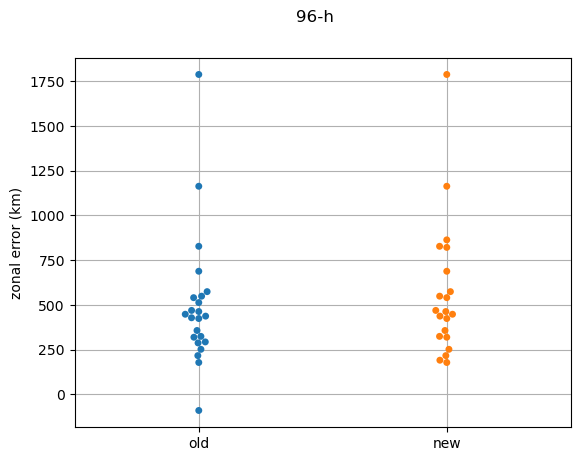

In [54]:
import seaborn as sns

daa = record_fcst_save["FERRX(km)"].astype(float)
data = [may_fcst_save["FERRX(km)"].astype(float).values, daa.values]
g = sns.swarmplot(data=data)
g.set_xticklabels(["old","new"])
g.set_ylabel("zonal error (km)")
plt.suptitle(f"{forecast_length}-h")
plt.grid(True)

In [34]:
for itime in itimes:
    itime = float(itime.strftime("%Y%m%d%H"))
    if itime not in [x for x in record_fcst_save.ITIME.values]:
        print(itime)

2020082918.0
2021040900.0
2021041112.0
2021123106.0


In [35]:
filtered_may_records - daa_records

{(2020082918, 38541.0),
 (2020102518, 39600.0),
 (2021040900, 42904.0),
 (2021040900, 42948.0)}

In [36]:
daa_records - filtered_may_records

{(2020040912, 35563.0), (2022041106, 50591.0)}

In [37]:
record_obs_save

,ITIME,FHOUR,ID,So(m/100km),LAT(N),LON(E),SoFlag,Ro(km),SR,BGo(m/100km),...,DIST(km),DT(h),DUR(h),MAXDUR(h),PTY-OVR,FERRY(km),FERRX(km),FERR(km),color,contains_zmin
18,2019102606,f000,32379,26.66,33.25,262.25,0,400.0,0.3,8.0,...,75.01,6.0,54.0,96.0,0.41,NaN,NaN,NaN,k,True
23,2019112706,f000,33027,30.26,40.0,266.0,0,500.0,0.93,28.24,...,351.08,6.0,42.0,156.0,0.42,NaN,NaN,NaN,k,True
18,2019122300,f000,33453,30.6,31.0,270.5,0,400.0,0.23,6.92,...,292.1,6.0,120.0,204.0,0.41,NaN,NaN,NaN,k,True
19,2020021206,f000,34433,16.38,30.25,250.25,0,800.0,0.72,11.81,...,326.03,6.0,120.0,138.0,0.67,NaN,NaN,NaN,k,True
21,2020022312,f000,34695,16.1,34.25,249.0,0,700.0,0.79,12.67,...,282.16,6.0,90.0,120.0,0.39,NaN,NaN,NaN,k,True
11,2020030400,f000,34916,24.03,28.0,250.75,0,500.0,0.62,14.93,...,196.41,6.0,72.0,108.0,0.43,NaN,NaN,NaN,k,True
21,2020040912,f000,35563,21.34,36.0,244.0,0,600.0,0.28,5.94,...,146.24,6.0,150.0,240.0,0.28,NaN,NaN,NaN,k,True
16,2020041212,f000,35563,17.9,29.75,255.25,0,500.0,1.16,20.72,...,508.32,6.0,222.0,240.0,0.3,NaN,NaN,NaN,k,True
20,2020051912,f000,36483,27.83,37.5,271.75,0,500.0,0.26,7.1,...,141.61,6.0,66.0,180.0,0.44,NaN,NaN,NaN,k,True
21,2020091000,f000,38671,22.93,36.5,249.25,0,500.0,0.35,8.05,...,86.33,6.0,54.0,144.0,0.11,NaN,NaN,NaN,k,True


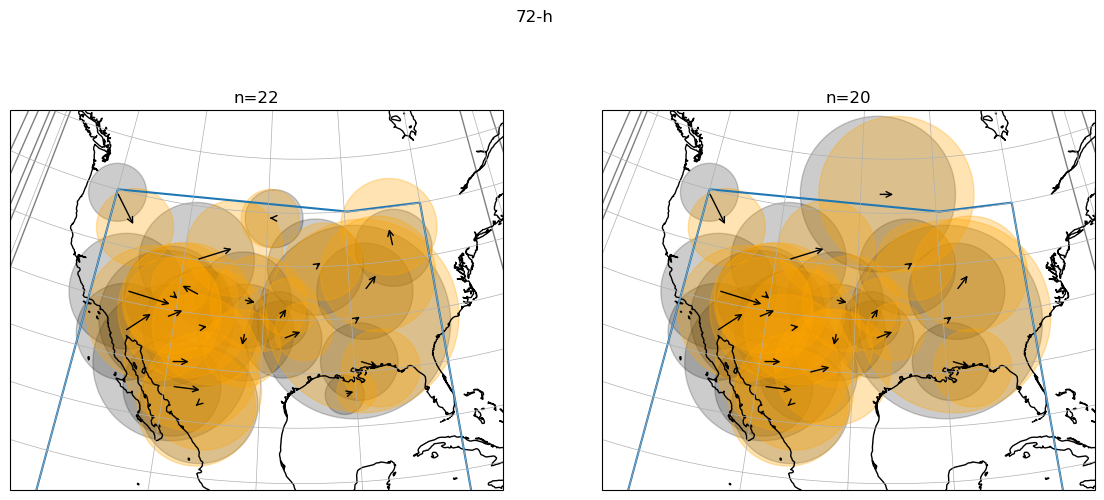

In [38]:
from matplotlib.patches import Rectangle

# Plot the COLs of interest
fig, axes = plt.subplots(
    ncols=2, figsize=(14, 6), subplot_kw={"projection": ccrs.LambertConformal()}
)
fig.suptitle(f"{forecast_length}-h")

for ax, (record_obs, record_fcst) in zip(
    axes, [(may_obs_save, may_fcst_save), (record_obs_save, record_fcst_save)]
):
    ax.plot([min_lon, min_lon, max_lon, max_lon, min_lon], [min_lat, max_lat, max_lat, min_lat, min_lat],
            transform=ccrs.PlateCarree()
    )
    ax.set_title(f"n={len(record_fcst)}")
    for _, row in record_fcst.iterrows():
        lon = row["LON(E)"]
        lat = row["LAT(N)"]

        # Define the lower-left corner of the box (lon-45, lat-45)
        lower_left = (lon - 45, lat - 45)
        width = 90  # span in longitude
        height = 90  # span in latitude

        rect = Rectangle(
            lower_left,
            width,
            height,
            facecolor="none",
            edgecolor="black",
            linewidth=1,
            alpha=0.5,
            transform=ccrs.PlateCarree(),  # because lon/lat are in geographic coords
        )
        ax.add_patch(rect)

    ts = tissot(ax, record_obs, alpha=0.2, color="k")
    ts = tissot(ax, record_fcst, alpha=0.3, color="orange")
    label_id(ax, record_fcst, markersize=0, linewidth=0)

    # Add coastlines
    ax.coastlines()
    ax.gridlines(lw=0.5)
    ax.set_extent((-123, -77, 18, 52))

In [23]:
ufsfld = "dt3dt"
fn = PKL_DIR / f"COMPOSITE_MEAN_{ufsfld[1:2].upper()}TEND_COMPONENTS_F{forecast_length:03d}_over_{twin}h.pkl"
print(fn)
if Path(fn).is_file():
    with open(fn, "rb") as data:
        [forecast_length, r, theta, levels, mean_polar_ufs] = pickle.load(data)
else:
    # **********************************************************************************************************
    #
    # Compute the composite of only the tendencies
    #
    # **********************************************************************************************************
    scope_radius = 45
    shape_r = 361

    # get the list of tendency components
    tendlist = list_components(ufsfld)

    mean_polar_ufs = np.zeros(shape=(len(tendlist), len(levels), shape_r, shape_r))
    count = 0  # reset counter of objects

    # Composite over all objects found for the forecast lead time
    for _, record_row in record_fcst_save.iterrows():
        print(record_row["ID"], record_row["LAT(N)"])

        # get COL object in analysis that matches the forecast object ID
        record_obs = record_obs_save[record_obs_save["ID"] == record_row["ID"]]
        valid_time = record_row.valid_time

        # loop through all vertical levels
        for k, sel_lev in enumerate(levels):
            # forecast variable
            for tnum, tendname in enumerate(tendlist):
                field = ufsfld + str(sel_lev) + "_" + tendname

                # forecast field to composite
                fld = ds[field].sel(Time=valid_time) - ds_p[field].sel(
                    Time=valid_time - timedelta(hours=twin)
                )

                # Only get the data near the cut-off low object
                # To plot, use draw_polar_map instead.

                theta, r, circdata_ufs = cutout_polar_map(
                    fld,
                    record_row["LAT(N)"],
                    record_row["LON(E)"],
                    scope_radius,
                    False,
                )  # (data, latc, lonc, radius in degrees)
                mean_polar_ufs[tnum, k, :, :] = mean_polar_ufs[tnum, k, :, :] + circdata_ufs

                # print("Added valid time = "+(itimes[tind]+timedelta(hours=forecast_length)).strftime('%Y%m%d%H') )

        count = count + 1

    print("Composited over " + str(count) + " COL events")
    mean_polar_ufs = mean_polar_ufs / count

    # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
    # RUN THE COMPUTE COMPOSITE BLOCK OF CODE FIRST
    # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

    # SAVE THE DATASET IN A PICKLE FILE
    with open(fn, "wb") as output:
        pickle.dump([forecast_length, r, theta, levels, mean_polar_ufs], output)

/glade/derecho/scratch/ahijevyc/UFS-MRW/TENDS_pickles/COMPOSITE_MEAN_TTEND_COMPONENTS_F096_over_18h.pkl
32379.0 40.25
33027.0 41.5
33453.0 29.75
34433.0 30.25
34695.0 36.0
34916.0 28.75
35563.0 35.25
35563.0 34.25
36483.0 38.0
38671.0 37.75
39553.0 33.0
40236.0 34.0
42385.0 37.25
43351.0 30.0
46789.0 40.75
46950.0 35.0
48354.0 37.5
49289.0 36.0
50591.0 46.75
51124.0 41.75
52004.0 42.75
Composited over 21 COL events


-0.0591129085363112
7.469399985812959
72
-3.9430009767945324
3.8434837630816867
72
-9.476516712279548
5.744167827424549
72
-2.8412622361488284
0.7479401139010277
72
-0.07116276191495843
0.5813237395018379
72
-0.0025566242499432215
0.0026427684400308258
72
-2.8217976774488176
-0.7294325147356305
72
0.13818117319302323
1.1586447727112543
72
0.0
0.0
72
-0.2718546905755125
0.8472917847597605
72


Text(0.5, 1.0, 'UFS 72-h fcst composite - sum of tends')

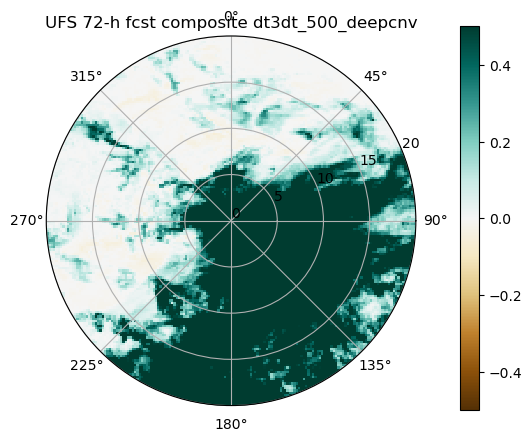

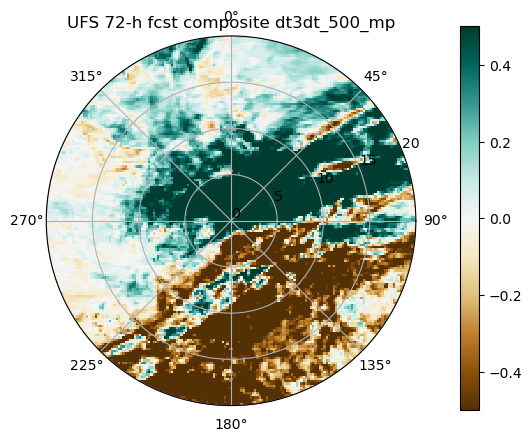

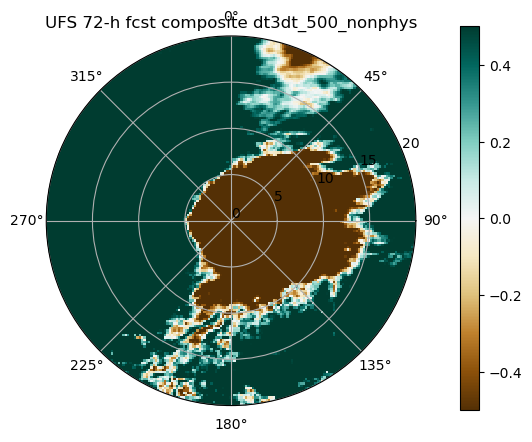

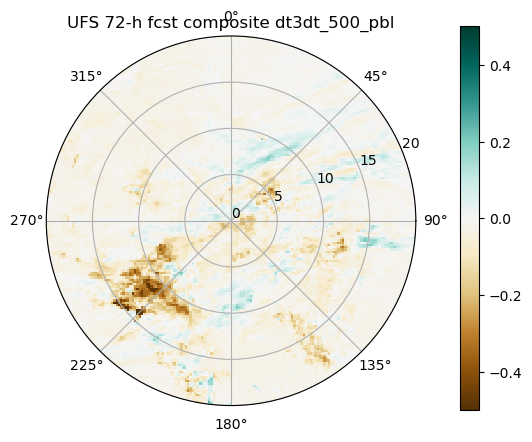

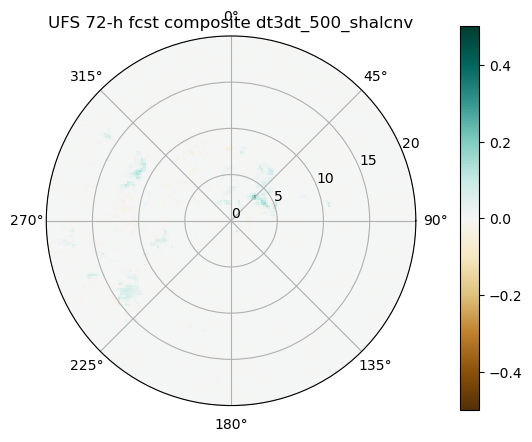

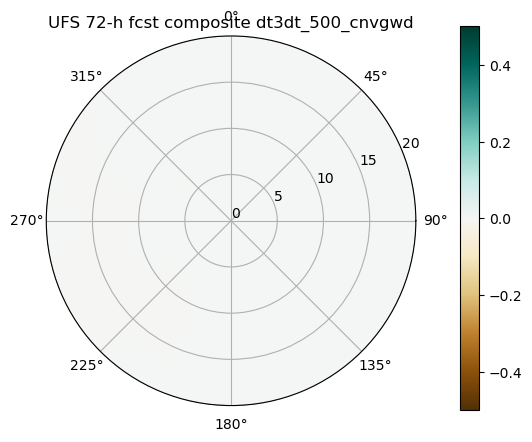

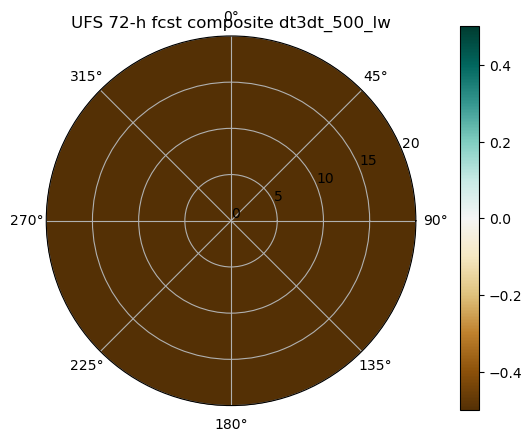

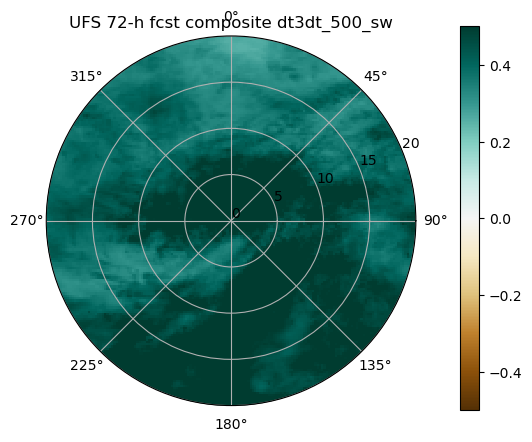

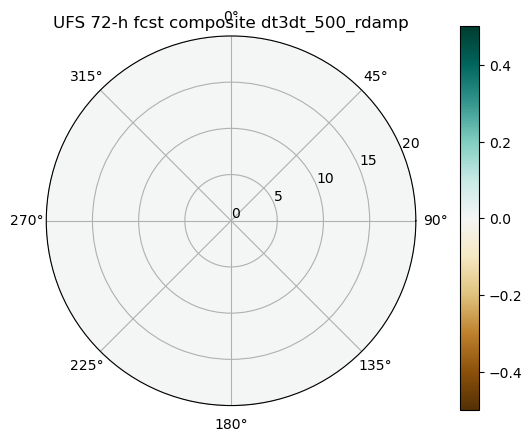

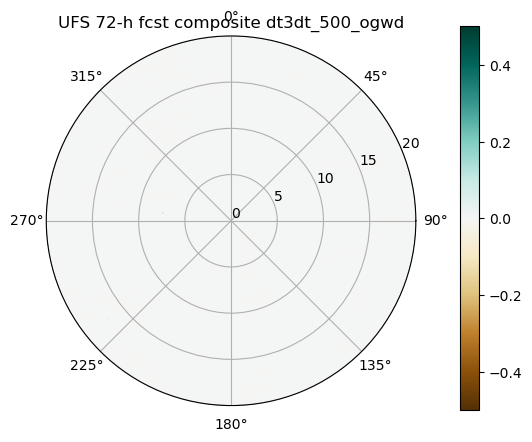

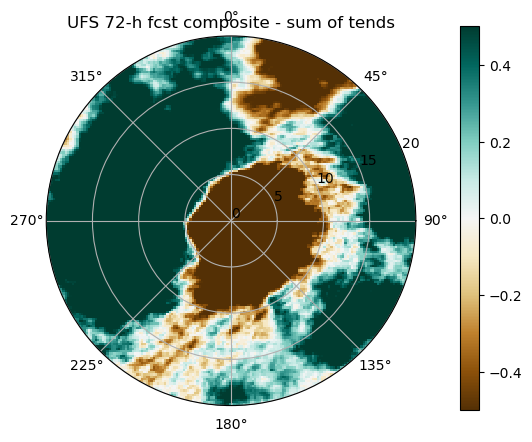

In [27]:
# *** PLOT THE MEAN POLAR MAPS
climit = 0.5
scope_radius_plot = 20
level = 500
ilev = levels.index(level)

# get the list of tendency components
tendlist = list_components(ufsfld)

local_sum = np.zeros(shape=(361, 361))

for tend2plt, tendcomp in enumerate(tendlist):
    # for tendnum in np.arange(0,1):
    # tend2plt = tendlist.index('nonphys')
    # tendcomp = tendlist[tend2plt]

    tendname = f"{ufsfld}_{level}_{tendcomp}"

    # Choose a different forecast lead time if desired
    for forecast_length in [72]:
        if False:
            fn = (
                PKL_DIR / f"COMPOSITE_MEAN_{ufsfld[1:2].upper()}TEND_COMPONENTS_F{forecast_length:03d}_over_{twin}h.pkl"
            )
            print(fn)

            if Path(fn).is_file():
                with open(fn, "rb") as data:
                    [forecast_length, r, theta, levels, mean_polar_ufs] = pickle.load(data)
            else:
                print("Cannot find file.")

        # This plots the mean:
        print(np.nanmin(mean_polar_ufs[tend2plt, ilev, :, :]))
        print(np.nanmax(mean_polar_ufs[tend2plt, ilev, :, :]))
        fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
        cs = ax.pcolormesh(
            theta,
            r,
            mean_polar_ufs[tend2plt, ilev, :, :],
            cmap="BrBG",
            vmin=-climit,
            vmax=climit,
        )
        local_sum = local_sum + mean_polar_ufs[tend2plt, ilev, :, :]

        ax.set_ylim([0, scope_radius_plot])
        radial_interval = 5
        ax.set_rgrids(np.arange(0, scope_radius_plot + radial_interval, radial_interval))
        cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
        fig.colorbar(cs, cax=cbaxes)
        ax.set_xticks(np.radians(np.arange(0, 360, 45)))
        ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
        ax.set_title(
            "UFS " + str(forecast_length) + "-h fcst composite " + tendname
        )  # composite tendencies')
        plt.savefig("UFS" + str(forecast_length) + "h_" + tendname + ".png")
    # Sometimes I forget which forecast hour we are looking at
    print(forecast_length)


# Plot sum of tendencies
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
cs = ax.pcolormesh(theta, r, local_sum[:, :], cmap="BrBG", vmin=-climit, vmax=climit)
ax.set_ylim([0, scope_radius_plot])
ax.set_rgrids(np.arange(0, scope_radius_plot + radial_interval, radial_interval))
cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
fig.colorbar(cs, cax=cbaxes)
ax.set_xticks(np.radians(np.arange(0, 360, 45)))
ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
ax.set_title(
    "UFS " + str(forecast_length) + "-h fcst composite - sum of tends"
)  # composite tendencies')

['deepcnv', 'mp', 'nonphys', 'pbl', 'shalcnv']
-0.0017485973577701468
0.0010332992020440066
-0.0015202850626259252
0.0025797028767143453
-0.003855147707370287
0.002100846957459691
-0.004161168377669085
0.004224660168845384
-0.002649604408621339
0.0012729803286746961


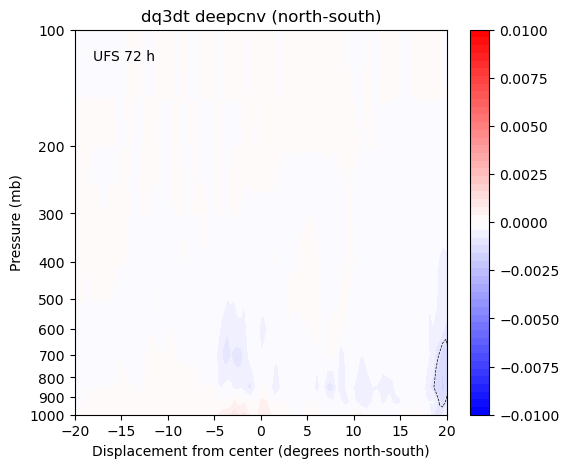

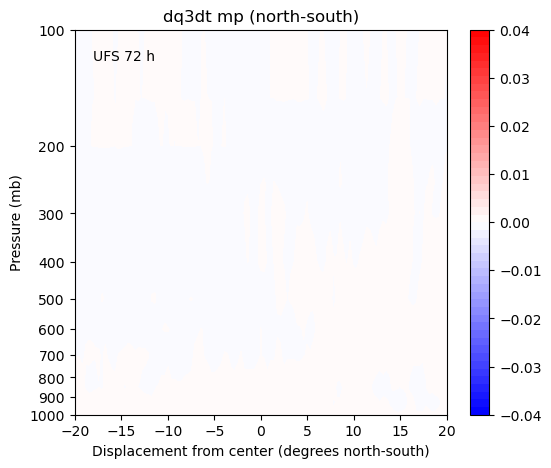

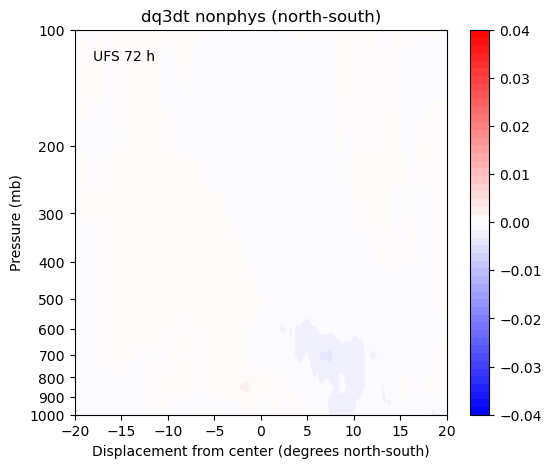

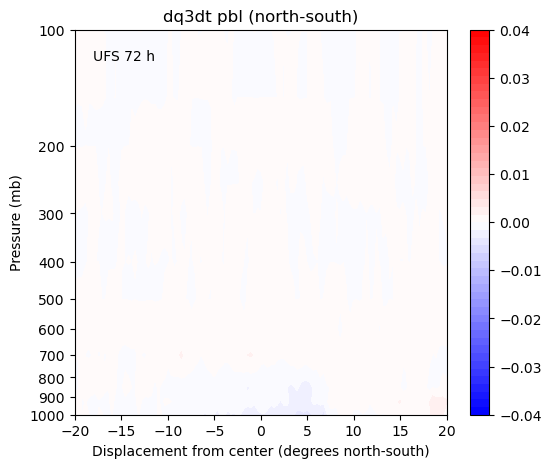

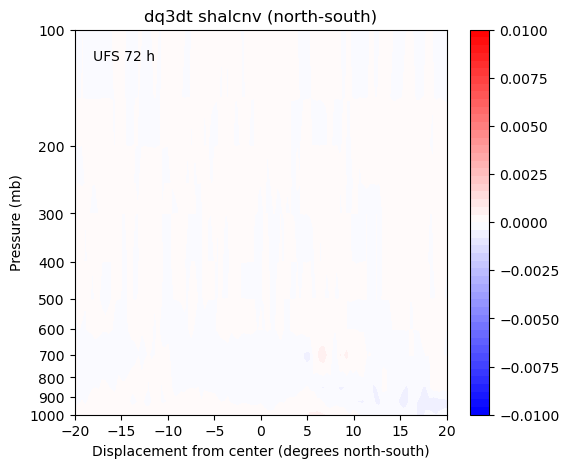

In [22]:
# Plot the vertical cross-sections (W-E or N-S)

# PuOr  for longwave
# RdYlBu for deepcnv
# RdBu for mp
# PiYG for dynamics

print(tendlist)
tend2pltlist = tendlist
# tend2pltlist = [ 'deepcnv', 'mp', 'nonphys' ]
# tend2pltlist = [ 'deepcnv' ,'lw' ,'mp', 'nonphys' ]
# tend2pltlist = [ 'pbl', 'shalcnv', 'cnvgwd', 'ogwd', 'rdamp']
for tname in tend2pltlist:
    tend2plt = tendlist.index(tname)
    tendcomp = tendlist[tend2plt]
    MIN, MAX = -0.04, 0.04
    selcmap = "bwr"
    if tname == "deepcnv":
        MIN, MAX = -1e-2, 1e-2
    elif tname == "shalcnv":
        MIN, MAX = -1e-2, 1e-2
    #     MIN, MAX = -4,4 # Color scale
    #     selcmap = 'RdYlBu_r'
    # elif ( tname == 'mp' ):
    # MIN, MAX = -5,5ax
    #     selcmap = 'RdBu_r'
    # elif ( tname == 'lw' ):
    #     MIN, MAX = -3,3
    #     selcmap = 'PuOr_r'
    # elif ( tname == 'nonphys'):
    #     MIN, MAX = -12,12
    #     selcmap = 'PiYG_r'
    # elif ( tname == 'pbl'):
    #     MIN,MAX = -12,12
    #     selcmap = 'RdBu_r'
    # elif ( tname == 'shalcnv' ):
    #     MIN,MAX = -3, 3
    #     selcmap = 'RdBu_r'
    # elif ( tname == 'cnvgwd' ):
    #     MIN,MAX = -0.01, 0.01
    #     selcmap = 'RdBu_r'
    # else:
    #     MIN,MAX = -0.4, 0.4
    #     selcmap = 'RdBu_r'

    for forecast_length in [72]:
        if forecast_length == 240:
            forecast_length = 96

        if False:
            fn = (
                PKL_DIR / f"COMPOSITE_MEAN_{ufsfld[1:2].upper()}TEND_COMPONENTS_F{forecast_length:03d}_over_{twin}h.pkl"
            )
            print(fn)
            if Path(fn).is_file():
                with open(fn, "rb") as data:
                    [forecast_length, r, theta, levels, mean_polar_ufs] = pickle.load(data)
            else:
                # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
                # RUN THE COMPUTE COMPOSITE BLOCK OF CODE FIRST
                # xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

                # SAVE THE DATASET IN A PICKLE FILE
                print("Run the compute composite block first!")

        # ------------------------------------------------------------------------------------
        #
        # Make vertical cross-sections of composite means
        #
        # ------------------------------------------------------------------------------------

        # # This plots the mean on the horizontal plane -- sanity checks.
        # scope_radius_plot = 45
        # fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
        # cs = ax.pcolormesh(theta, r, mean_polar_ufs[5,:,:], cmap='seismic', vmin=-climit, vmax=climit)
        # ax.set_ylim([0,scope_radius_plot])
        # ax.yaxis.set_tick_params(labelleft=False)
        # cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
        # fig.colorbar(cs, cax=cbaxes)
        # ax.set_xticklabels(['90°', '45°', '0°', '315°', '270°', '225°', '180°', '135°'])
        # ax.set_title('UFS 24-h fcst composite tendencies')

        ufs = True
        gfs = False

        west_east = False
        north_south = True
        fig, ax = plt.subplots(figsize=(6, 5))
        radlim = 20  # radius to plot

        [xmesh, zmesh] = np.meshgrid(np.linspace(-np.max(r), np.max(r), len(r[0, :-1])), levels)

        if ufs:
            fld = mean_polar_ufs[tend2plt, :, :, :]
            label_in_plot = "UFS " + str(forecast_length) + " h"
        elif gfs:
            fld = mean_polar_gfs
            label_in_plot = "GFS analysis"

        if north_south:
            print(np.min(np.fliplr(fld[:, :, 180])))
            print(np.max(np.fliplr(fld[:, :, 180])))
            cf = plt.contourf(
                xmesh, zmesh, np.fliplr(fld[:, :, 180]), np.linspace(MIN, MAX, 51), cmap=selcmap
            )
            plt.contour(
                xmesh,
                zmesh,
                np.fliplr(fld[:, :, 180]),
                np.linspace(MIN, MAX, 10),
                colors="k",
                linewidths=0.5,
            )
            plt.title(ufsfld + " " + tname + " (north-south)")
            plt.xlabel("Displacement from center (degrees north-south)")
        elif west_east:
            print(np.min(fld[:, 180, :]))
            print(np.max(fld[:, 180, :]))

            cf = plt.contourf(xmesh, zmesh, fld[:, 180, :], np.linspace(MIN, MAX, 51), cmap=selcmap)
            plt.contour(
                xmesh,
                zmesh,
                fld[:, 180, :],
                np.linspace(MIN, MAX, 10),
                colors="k",
                linewidths=0.5,
            )
            plt.title(ufsfld + " " + tname + " (west-east)")
            plt.xlabel("Displacement from center (degrees west-east)")

        ax.set_yscale("log")
        plt.ylim([np.min(levels), np.max(levels)])
        plt.ylim([400, 600])
        plt.yticks(np.arange(100, 1100, 100))
        ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
        plt.gca().invert_yaxis()
        plt.ylabel("Pressure (mb)")

        plt.xlim([-radlim, radlim])
        cbar = plt.colorbar(cf)
        cblim = MAX
        if cblim >= 10:
            cbint = 2.0
        elif cblim <= 1.0:
            cbint = cblim / 4.0
        else:
            cbint = 1.0
        cbar.set_ticks(np.arange(-cblim, cblim + cbint, cbint))
        plt.text(-radlim + 2, 120, label_in_plot)

        if west_east:
            plt.savefig("west_east_" + str(forecast_length) + "h_accumulated_" + tname + ".png")
        elif north_south:
            plt.savefig("north_south_" + str(forecast_length) + "h_accumulated_" + tname + ".png")

Added valid time = 2019102606
Added valid time = 2019112706
Added valid time = 2019122300
Added valid time = 2020021206
Added valid time = 2020022312
Added valid time = 2020030400
Added valid time = 2020040912
Added valid time = 2020041212
Added valid time = 2020051912
Added valid time = 2020091000
Added valid time = 2020102818
Added valid time = 2020112806
Added valid time = 2021031718
Added valid time = 2021050106
Added valid time = 2021101918
Added valid time = 2021102906
Added valid time = 2022021612
maxy > 90, pad with nan
Added valid time = 2022041406
Added valid time = 2022050512
Added valid time = 2022061418
Compositing over 20 COL events
anl_t500.F072h.png
UFS_t500.F072h.png
72


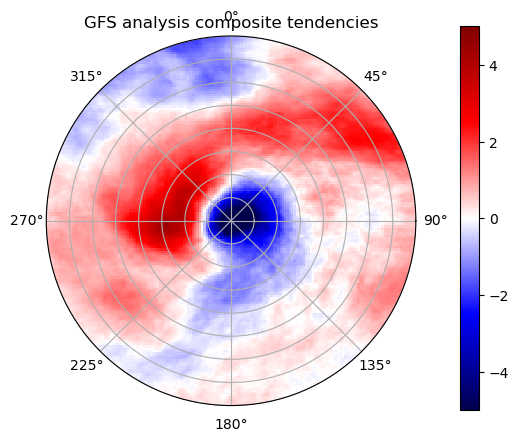

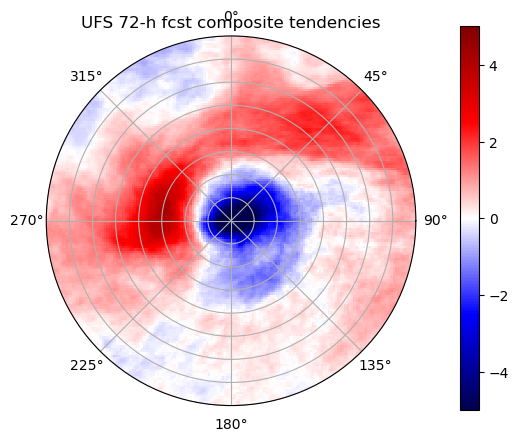

In [23]:
# **********************************************************************************************************
#
# Plot the composites
#
# **********************************************************************************************************
sel_lev = 500  # choose pressure level
field = "t" + str(sel_lev)
gfsfld = "TMP"
shortName = "t"
scope_radius = 45
shape_r = 361

# Create an xarray to store the composite fields
ds["meanfld_ufs"] = xarray.zeros_like(ds[field].isel(Time=0))

ds1 = get_GFS_analyses_single_level(
    (itimes[0] + timedelta(hours=forecast_length - twin)).strftime("%Y%m%d%H"), [sel_lev]
)

dsmean = ds1.copy()
dsmean = dsmean.assign(meanfld_gfs=dsmean[gfsfld + "_" + str(sel_lev) + "mb"][0, :, :] * 1.0)
dsmean["meanfld_gfs"] = xarray.zeros_like(ds["meanfld_ufs"])

#####
count = 0
mean_polar_gfs = np.zeros(shape=(shape_r, shape_r))
mean_polar_ufs = np.zeros(shape=(shape_r, shape_r))
for _, record_row in record_fcst_save.iterrows():
    itime = pd.to_datetime(record_row.ITIME, format="%Y%m%d%H")
    valid_time = itime + pd.Timedelta(hours=forecast_length)
    # get COL object in analysis that matches the forecast object ID
    record_obs = getobs(valid_time, ids=[record_row.ID]).squeeze()

    # Get GFS analysis fields to get the domain averages over the object
    # anl_tmp2 = get_GFS_analyses_all_levels( valid_timeobject.strftime('%Y%m%d%H'), 'TMP', levels)
    # anl_tmp1 = get_GFS_analyses_all_levels( (valid_timeobject - timedelta(hours=twin)).strftime('%Y%m%d%H'), 'TMP', levels)

    # get the forecast composite
    fld = ds[field].sel(Time=valid_time) - ds_p[field].sel(Time=valid_time - timedelta(hours=twin))
    ds["meanfld_ufs"] = ds["meanfld_ufs"] + fld

    # get analysis composite
    # ds1 = get_GFS_analyses_single_level(
    #    (itime + timedelta(hours=forecast_length - twin)).strftime("%Y%m%d%H"),
    #    [sel_lev],
    # )

    test = get_obsds(
        itime + timedelta(hours=forecast_length - twin), level=sel_lev, shortName=shortName
    )
    ds1 = (
        test.assign_coords(lon=(test["lon"] % 360))
        .sortby(["lon", "lat"])
        .rename(f"{gfsfld}_{sel_lev}mb")
        .rename(lat="latitude", lon="longitude")
    )

    # assert np.array_equal(ds1[f"{gfsfld}_{sel_lev}mb"].squeeze(dim="time").values, test.values)

    # ds2 = get_GFS_analyses_single_level(
    #    (itime + timedelta(hours=forecast_length)).strftime("%Y%m%d%H"), [sel_lev]
    # )
    ds2 = get_obsds(itime + timedelta(hours=forecast_length), level=sel_lev, shortName=shortName)
    ds2 = (
        ds2.assign_coords(lon=(test["lon"] % 360))
        .sortby(["lon", "lat"])
        .rename(f"{gfsfld}_{sel_lev}mb")
        .rename(lat="latitude", lon="longitude")
    )

    # gfs_fld = (
    #    ds2[gfsfld + "_" + str(sel_lev) + "mb"].squeeze(dim="time")
    #    - ds1[gfsfld + "_" + str(sel_lev) + "mb"].squeeze(dim="time")
    # )
    gfs_fld = ds2 - ds1
    dsmean["meanfld_gfs"] = dsmean["meanfld_gfs"] + gfs_fld
    # Make plots
    # ax_obs, theta, r, circdata_obs = draw_polar_map(
    # ds2[gfsfld+'_'+str(sel_lev)+'mb'][0,:,:]-ds1[gfsfld+'_'+str(sel_lev)+'mb'][0,:,:], record_obs['LAT(N)'], record_obs['LON(E)'], scope_radius, True)
    # (data, latc, lonc, radius in degrees)
    # ax_ufs, theta, r, circdata_ufs = draw_polar_map( fld, record_row['LAT(N)'], record_row['LON(E)'], scope_radius, False) # (data, latc, lonc, radius in degrees)
    # Just get the data near the cut-off low object
    theta, r, circdata_obs = cutout_polar_map(
        gfs_fld,
        record_obs["LAT(N)"],
        record_obs["LON(E)"],
        scope_radius,
        True,
    )  # (data, latc, lonc, radius in degrees)
    # print(itime, ds1[gfsfld + "_" + str(sel_lev) + "mb"].shape, ds2[gfsfld + "_" + str(sel_lev) + "mb"].shape, circdata_obs.shape, record_obs["LAT(N)"])
    theta, r, circdata_ufs = cutout_polar_map(
        fld,
        record_row["LAT(N)"],
        record_row["LON(E)"],
        scope_radius,
        False,
    )  # (data, latc, lonc, radius in degrees)

    mean_polar_gfs = mean_polar_gfs + circdata_obs.values
    mean_polar_ufs = mean_polar_ufs + circdata_ufs

    # ax_obs.set_title('GFS analysis valid at '+(itime+timedelta(hours=forecast_length)).strftime('%Y%m%d%H'))
    # ax_ufs.set_title('UFS 48-h fcst valid at '+(itime+timedelta(hours=forecast_length)).strftime('%Y%m%d%H'))

    print("Added valid time = " + (itime + timedelta(hours=forecast_length)).strftime("%Y%m%d%H"))
    count = count + 1

print("Compositing over " + str(count) + " COL events")
ds["meanfld_ufs"] = ds["meanfld_ufs"] / count
dsmean["meanfld_gfs"] = dsmean["meanfld_gfs"] / count

mean_polar_gfs = mean_polar_gfs / count
mean_polar_ufs = mean_polar_ufs / count

# *** PLOT THE MEAN POLAR MAPS
climit = 5
scope_radius = 20

# This plots the mean:
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
cs = ax.pcolormesh(theta, r, mean_polar_gfs, cmap="seismic", vmin=-climit, vmax=climit)
ax.set_ylim([0, scope_radius])
ax.yaxis.set_tick_params(labelleft=False)
cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
fig.colorbar(cs, cax=cbaxes)
ax.set_xticks(np.arange(0, np.pi * 2, np.pi / 4))
ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
ax.set_title("GFS analysis composite tendencies")
ofile = f"anl_{field}.F{forecast_length:03d}h.png"
fig.savefig(ofile)
print(ofile)

# This plots the mean:
fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
cs = ax.pcolormesh(theta, r, mean_polar_ufs, cmap="seismic", vmin=-climit, vmax=climit)
ax.set_ylim([0, scope_radius])
ax.yaxis.set_tick_params(labelleft=False)
cbaxes = fig.add_axes([0.87, 0.1, 0.03, 0.8])
fig.colorbar(cs, cax=cbaxes)
ax.set_xticks(np.arange(0, np.pi * 2, np.pi / 4))
ax.set_xticklabels(["90°", "45°", "0°", "315°", "270°", "225°", "180°", "135°"])
ax.set_title(f"UFS {forecast_length}-h fcst composite tendencies")
ofile = f"UFS_{field}.F{forecast_length:03d}h.png"
fig.savefig(ofile)
print(ofile)
print(forecast_length)

In [24]:
ds2

<xarray.DataArray 'TMP_500mb' (latitude: 721, longitude: 1440)> Size: 4MB
[1038240 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    pfull       float64 8B ...
  * latitude    (latitude) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
    valid_time  datetime64[ns] 8B ...
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Attributes: (12/30)
    GRIB_paramId:                             130
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Temperature
    GRIB_shortName:                           t
    GRIB_units:                               K
    long_name:                                Temperature
    units:                                    K
    standard_name:                            air_temperature

In [25]:
test

<xarray.DataArray 't' (lat: 721, lon: 1440)> Size: 4MB
[1038240 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    pfull       float64 8B ...
  * lat         (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
    valid_time  datetime64[ns] 8B ...
  * lon         (lon) float64 12kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Attributes: (12/30)
    GRIB_paramId:                             130
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         isobaricInhPa
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                Temperature
    GRIB_shortName:                           t
    GRIB_units:                               K
    long_name:                                Temperature
    units:                                    K
    standard_name:                            air_temperature

In [57]:
ds[field].isel(Time=0).squeeze().expand_dims(dim={"levels": levels})

<xarray.DataArray 't100' (levels: 12, south_north: 721, west_east: 1440)> Size: 50MB
dask.array<broadcast_to, shape=(12, 721, 1440), dtype=float32, chunksize=(12, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * levels   (levels) int64 96B 1000 925 850 700 600 500 400 300 250 200 150 100
    XLONG    (south_north, west_east) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    XLAT     (south_north, west_east) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    Time     datetime64[ns] 8B 2019-10-26T06:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    MemoryOrder:  XY
    units:        K
    description:  100-mb temperature
    stagger:      
    FieldType:    104

In [30]:
# **********************************************************************************************************
# Compute the domain-averaged vertical profiles using the matched forecast and analysis objects (ID)
#
# **********************************************************************************************************

s = np.zeros(shape=(len(record_fcst_save), len(levels)))
g = np.zeros(shape=(len(record_fcst_save), len(levels)))
field = "t500"

fld = np.zeros((len(levels), ds.south_north.size, ds.west_east.size))


print(s.shape)
for col_index, record_row in record_fcst_save.reset_index().iterrows():
    # get valid time for the cut-off low object
    valid_time = record_row.valid_time

    # get COL object in analysis that matches the forecast object ID
    record_obs = record_obs_save[record_obs_save["ID"].values == record_row["ID"]]

    # Get GFS analysis fields to get the domain averages over the object
    anl_tmp2 = get_GFS_analyses_all_levels(valid_time.strftime("%Y%m%d%H"), "TMP", levels)
    anl_tmp1 = get_GFS_analyses_all_levels(
        (valid_time - timedelta(hours=twin)).strftime("%Y%m%d%H"), "TMP", levels
    )

    # anl_rh2 = get_GFS_analyses_all_levels( valid_time.strftime('%Y%m%d%H'), 'RH', levels )
    # anl_rh1 = get_GFS_analyses_all_levels( (valid_time - timedelta(hours=twin)).strftime('%Y%m%d%H'), 'RH', levels)

    # anl_spfh2 = convert_rh_to_spfh( anl_tmp2[:,:,:], anl_rh2[:,:,:], levels)
    # anl_spfh1 = convert_rh_to_spfh( anl_tmp1[:,:,:], anl_rh1[:,:,:], levels)
    # print("Done converting")

    # Scale the radius of the object
    scale_Ro = 0.5

    for ik, l in enumerate(levels):
        field = "t" + str(l)
        fld[ik, :, :] = ds[field].sel(
            Time=valid_time
        )  # -ds_p[field].sel(Time=valid_time-timedelta(hours=twin))
    fld = flip_londim(fld)
    s[col_index, :] = get_domave(fld, xlon, xlat, record_row, scale_Ro, np.linspace(-20, 20, 30))

    fld = anl_tmp2  # - anl_tmp1
    # fld = anl_spfh2 - anl_spfh1
    g[col_index, :] = get_domave(fld, xlon, xlat, record_obs, scale_Ro, np.linspace(-20, 20, 30))
    print("Done averaging. next")

(21, 12)
Done averaging. next
Done averaging. next
Done averaging. next
Done averaging. next
Done averaging. next
Done averaging. next


ValueError: cannot reshape array of size 4 into shape (1,2)

72
0.0
296.44118914580713


Text(0, 0.5, 'Pressure (hPa)')

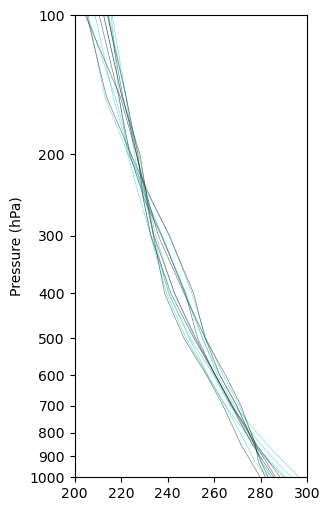

In [28]:
import matplotlib.ticker as mticker

print(forecast_length)

print(np.min(s))
print(np.max(s))
# fig = plt.figure(figsize=(3,6))
fig = plt.figure(figsize=(3, 6))
plt.plot(np.transpose(s), levels, "c", alpha=0.5, linewidth=0.5, label="UFS-MRW")
plt.plot(np.transpose(g), levels, "k", alpha=0.5, linewidth=0.5, label="GFS analysis")


plt.plot(np.nanmean(np.transpose(s), axis=1), levels, "r-", linewidth=3.0)
plt.plot(np.nanmean(np.transpose(g), axis=1), levels, "k--", linewidth=2.0)
plt.gca().invert_yaxis()
ax = plt.gca()
clim = 0.002
# plt.xlim([-clim, clim])
plt.xlim([200, 300])
# plt.yticklabels(levels)
plt.yscale("log")
plt.yticks(levels)
plt.yscale("log")
plt.ylim([np.min(levels), np.max(levels)])
plt.yticks(np.arange(100, 1100, 100))
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
plt.plot([0, 0], [np.min(levels), np.max(levels)], "k--", linewidth=1.0)
plt.gca().invert_yaxis()
# plt.xlabel(f'Spec. hum. change (kg/kg) over {twin} h')
plt.ylabel("Pressure (hPa)")

In [29]:
forecast_length

72

In [ ]:
# Composite ideas
#
# - Filter by radius size?
# - Composite with km x km as dimensions and then centered around the center of the COL object